The goal of this assignment is to write a simple particle simulator. Assume we have $N$ particles with strength $k_j > 0$ at the positions $x_j\in\mathbb{R}^2$, $j=0,\dots, N-1$. Each particle creates a potential at a given point $x$ of strength $V_j(x) = -k_j\log |x-x_j|$. The total potential at a given position $x$ is therefore
$$
V(x) = -\sum_{j=0}^{N-1}k_j\log|x-x_j|.
$$

In [13]:
import time
import timeit
import numpy as np
from numpy import linalg as LA
from numba import jit, prange
import pyopencl as cl
from matplotlib import pyplot as plt
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [14]:
N = np.int32(100)
rand = np.random.RandomState(0)
pos = rand.rand(N, 2)
k = rand.rand(N)

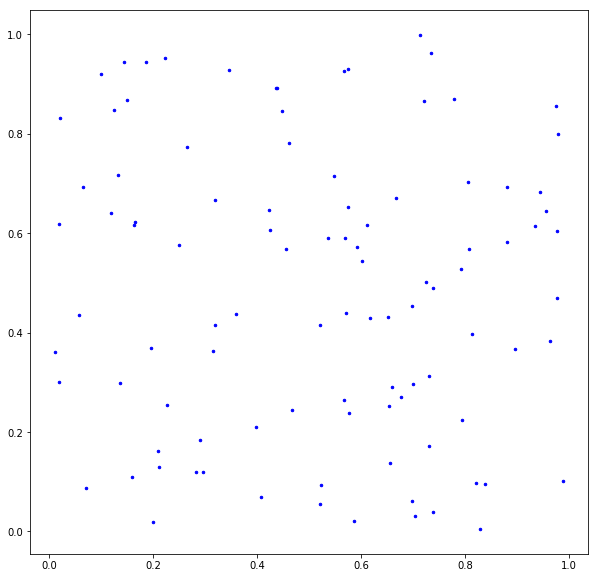

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(pos[:, 0], pos[:, 1], 'b.', markersize=5)

In [16]:
@jit(nopython=True,parallel=True)
def evaluate_field_numba(evaluation_points, source_points, strength_vector):
    """Numba implementation of the evaluate_field function
    """
    field = np.zeros(len(evaluation_points), np.float64)
    for i in prange(len(evaluation_points)):
        potential = np.float64(0)
        for j in prange(len(source_points)):
            norm = LA.norm(evaluation_points[i] - source_points[j])
            potential -= strength_vector[j] * (np.log(norm))
        field[i] = potential
    
    return field

In [17]:
def evaluate_field_opencl(evaluation_points, source_positions,
                          strength_vector):
    """OpenCL implementation of the evaluate_field function
    """
    
    kernel = """
    __kernel void evaluate_potential(const int N,
                                    __global double *evaluationPoints,
                                    __global double *sourcePoints,
                                    __global double *strengthVector,
                                    __global double *field)
    {
        //Identifies the thread
        int i = get_global_id(0);
        
        //Resets potential matrix element
        double potential = 0.0f;
        
        //Evaluates the x and y values required to calculate the norm
        for(int j = 0; j < N; j++)
        {
            double currX = evaluationPoints[2 * i] - sourcePoints[2 * j];
            double currY = evaluationPoints[2 * i + 1] - sourcePoints[2 * j + 1];
            
            //Evaluates the norm
            //double norm = sqrt(pow(currX,2) + pow(currY,2));
            double norm = 1.0;
            //Evaluates the potential
            potential -= strengthVector[j] * log(norm);
        }
        
        //Fills the field matrix with potentials
        field[i] = potential;
    }
    """
    #this converts the evaluation points into a 1d array
    #which is required when passed to the kernel.
    evaluation_points = np.ascontiguousarray(evaluation_points) 
    n_eval_points = len(evaluation_points)
    n_source_points = np.int32(source_positions.shape[0])
    
    mf = cl.mem_flags
    
    eval_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY,
                            hostbuf=evaluation_points)
    source_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY,
                              hostbuf=source_positions)
    strength_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY,
                                hostbuf=strength_vector)
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR,
                              size=evaluation_points.shape[0] * 8)
                            
    prg = cl.Program(ctx, kernel)
    prg.build()
    potential_kernel = prg.evaluate_potential
    
    potential_kernel(queue, (n_eval_points, ), (1, ), n_source_points,
                     eval_buffer, source_buffer, strength_buffer,
                     result_buffer)
    
    field, _ = cl.enqueue_map_buffer(queue, result_buffer,
                                     cl.map_flags.READ, 0,
                                     (n_eval_points,), np.double)
    queue.finish()
    
    return field


In [18]:
def evaluate_field(evaluation_points, source_points, strength_vector, 
                   implementation='numba'):
    """This function chooses which implementation of evaluate field is used.
    """
    if implementation == 'numba':
        return evaluate_field_numba(evaluation_points,source_points, 
                                    strength_vector)
    
    if implementation == 'opencl':
        return evaluate_field_opencl(evaluation_points,source_points, 
                                     strength_vector)
    

In [19]:
test_evaluation_points = np.array([[1.5, 1.3], [1.8, 1.6]], np.float64)

result_numba = evaluate_field(
    test_evaluation_points, pos, k, implementation='numba')
result_opencl = evaluate_field(
    test_evaluation_points, pos, k, implementation='opencl')

print(result_numba)
print(result_opencl)

[-12.04897855 -26.74485914]
[0. 0.]


In [20]:
Nx = 100
Ny = 100
xpoints, ypoints = np.mgrid[0: 1: 1j * Nx, 0: 1: 1j * Ny]
evaluation_points = np.vstack([xpoints.ravel(), ypoints.ravel()]).T

In [21]:
class Timer:

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [22]:
with Timer() as t:
    result_numba = evaluate_field(evaluation_points, pos, k, 
                                  implementation='numba')
print(t.interval)

with Timer() as t:
    result_opencl = evaluate_field(evaluation_points, pos, k, 
                                   implementation='opencl')
print(t.interval)

1.5836079120635986
0.00921010971069336


In [23]:
result_numba = np.log10(np.abs(result_numba.reshape(Nx, Ny)))
result_opencl = np.log10(np.abs(result_opencl.reshape(Nx, Ny)))

/usr/local/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'OpenCL')

/usr/local/bin/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/bin/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/bin/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/bin/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/usr/local/bin/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/bin/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a

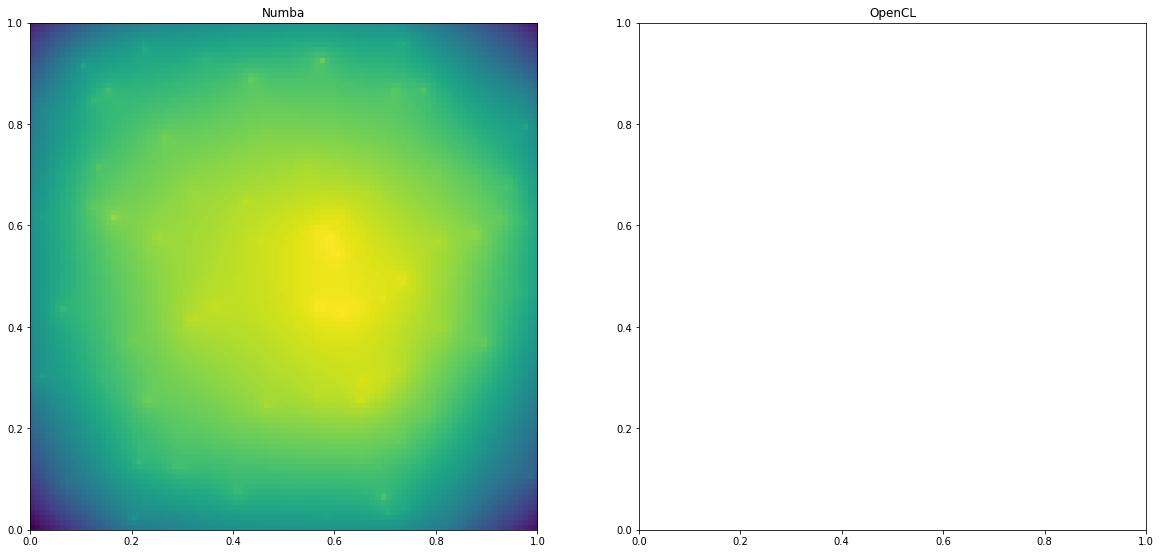

In [24]:
figure = plt.figure(figsize=(20, 20))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

ax1.imshow(result_numba.T, extent=[0, 1, 0, 1], origin='lower')
ax1.set_aspect('equal')
ax1.set_title('Numba')

ax2.imshow(result_opencl.T, extent=[0, 1, 0, 1], origin='lower')
ax2.set_aspect('equal')
ax2.set_title('OpenCL')